In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.optimize import curve_fit
from scipy.integrate import simps

import lightkurve as lk

import pickle

from datetime import datetime

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [3]:
coinciding_flares_df = pd.read_pickle('..\..\data\spt_tess_candidates_tandoi24.pkl')
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors', 'TIC'],
      dtype='object')


,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors,TIC
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28],TIC229807000
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28],TIC279255411
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29],TIC207138379
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30],TIC401838575


In [4]:
flare_star = coinciding_flares_df.iloc[3]

In [5]:
SPT_SS = pd.read_csv('../../data/SPT/flux_calibrated_catalog_scan_start_times_26feb25.csv')

TIC401838575


Text(0.5, 0, 'MJD')

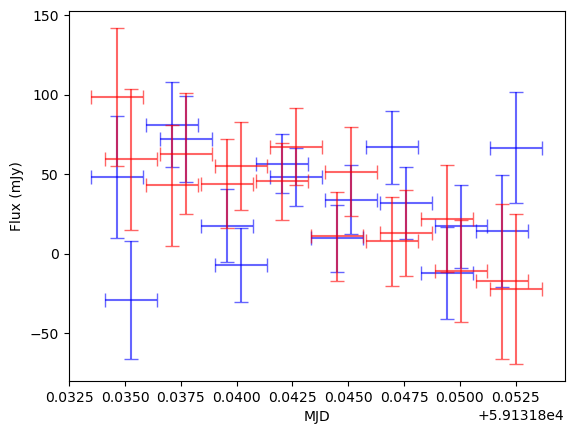

In [6]:
spt_id = flare_star['spt_id']
gaia = flare_star['dr3_source_id']
TIC = flare_star['TIC']
print(TIC)

d = (flare_star['parallax']*u.mas).to(u.cm, equivalencies= u.parallax())
# d = 1/pi -> d_err = sigma_pi / pi^2 = sigma_pi/pi * d
d_err = (flare_star['parallax_err'] * u.mas / (flare_star['parallax'] * u.mas) * d)

'''
SPT (quiescent signal is ~0 mJy)
'''
# Grab SPT Single Scan Data
ss_t0 = SPT_SS[SPT_SS['DR3_source_id']== gaia]['scan_start_time_mjd'].values[0]

ss_times_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_times'].values[0]
ss_times_str_dict = eval(ss_times_str.replace('array', 'np.array'))
ss_times_90 = ss_times_str_dict['90GHz'] / (60*24) + ss_t0
ss_times_150 = ss_times_str_dict['150GHz'] / (60*24) + ss_t0

ss_flux_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux'].values[0]
ss_flux_str_dict = eval(ss_flux_str.replace('array', 'np.array'))
ss_flux_90 = ss_flux_str_dict['90GHz']
ss_flux_150 = ss_flux_str_dict['150GHz']

ss_flux_err_str = SPT_SS[SPT_SS['DR3_source_id']== gaia]['ss_flux_err'].values[0]
ss_flux_err_str_dict = eval(ss_flux_err_str.replace('array', 'np.array'))
ss_flux_err_90 = ss_flux_err_str_dict['90GHz']
ss_flux_err_150 = ss_flux_err_str_dict['150GHz']

# Plot SPT Lightcurves |  * 1e-26 * 22.7e9 * (4*np.pi*d**2)
plt.errorbar(ss_times_90, ss_flux_90, yerr= np.abs(ss_flux_err_90), xerr= 100/(24*3600), c= 'b', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 95 GHz')
plt.errorbar(ss_times_150, ss_flux_150, yerr= np.abs(ss_flux_err_150), xerr= 100/(24*3600), c= 'r', fmt='none', alpha= 0.6, capsize=5, label= 'SPT-3G 150 GHz')

plt.ylabel('Flux (mJy)')
plt.xlabel('MJD')
# plt.yscale('log')

In [7]:
# Prepare data for fitting
t_peak_90 = ss_times_90[np.argmax(ss_flux_90)]
ss_times_90_shifted = ss_times_90 - t_peak_90

t_peak_150 = ss_times_150[np.argmax(ss_flux_150)]
ss_times_150_shifted = ss_times_150 - t_peak_150

scaling_90 = np.max(ss_flux_90)  # Scale factor for normalization
ss_flux_90_rel = ss_flux_90 / scaling_90  # Normalize the flux for fitting

scaling_150 = np.max(ss_flux_150)  # Scale factor for normalization
ss_flux_150_rel = ss_flux_150 / scaling_150  # Normalize the flux for fitting

Text(0.5, 1.0, 'Normalized Flux')

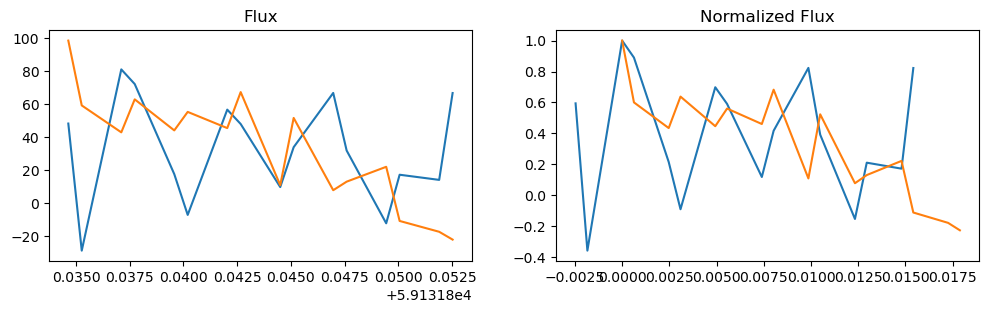

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(ss_times_90, ss_flux_90)
ax1.plot(ss_times_150, ss_flux_150)
ax1.set_title('Flux')
ax2.plot(ss_times_90_shifted, ss_flux_90_rel)
ax2.plot(ss_times_150_shifted, ss_flux_150_rel)
ax2.set_title('Normalized Flux')

In [9]:
def gauss(t, t_peak, amp, sigma):
    """Simple Gaussian function for flare fitting.
        Suggested by Howard and MacGregor (2023) for non_optical flares.
    """
    result = np.zeros_like(t)
    result = amp * np.exp(-0.5 * ((t - t_peak) / sigma) ** 2)
    return result

def double_gauss_shared_peak(tup, amp_90, sigma_90, amp_150, sigma_150, t_peak):
    t_90, t_150 = tup
    g90 = gauss(t_90, t_peak, amp_90, sigma_90)
    g150 = gauss(t_150, t_peak, amp_150, sigma_150)
    return np.concatenate([g90, g150])

[-1.89996081e-04  4.78134012e-01  1.64904926e-02]
[0.00146867 0.67652388 0.006835  ]


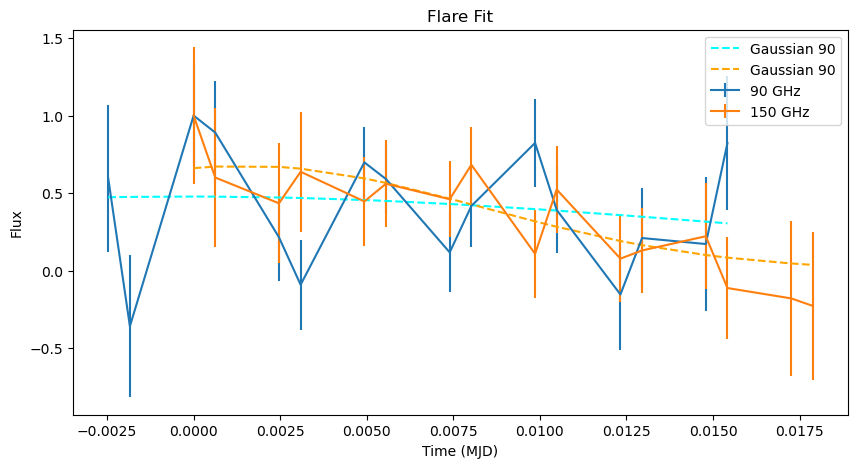

In [10]:
# Initial parameter guesses for primary flare peak
p0 = [0, np.max(ss_flux_90_rel), 0.005]

popt_90, pcov_90 = curve_fit(gauss, ss_times_90_shifted, ss_flux_90_rel, sigma= np.abs(ss_flux_err_90) / scaling_90, maxfev=10000)
print(popt_90)
t_peak_90, amp_90, sigma_90 = popt_90
sigma_90 = np.abs(sigma_90)  # Ensure sigma is positive
model_90 = gauss(ss_times_90_shifted, *popt_90)

p0 = [0, np.max(ss_flux_150_rel), 0.005]
popt_150, pcov_150 = curve_fit(gauss, ss_times_150_shifted, ss_flux_150_rel, sigma= np.abs(ss_flux_err_150) / scaling_150, maxfev=10000)
print(popt_150)
t_peak_150, amp_150, sigma_150 = popt_150
sigma_150 = np.abs(sigma_150)  # Ensure sigma is positive
model_150 = gauss(ss_times_150_shifted, *popt_150)


plt.figure(figsize=(10, 5))
plt.errorbar(ss_times_90_shifted, ss_flux_90_rel, yerr= np.abs(ss_flux_err_90) / scaling_90, label='90 GHz')
plt.errorbar(ss_times_150_shifted, ss_flux_150_rel, yerr= np.abs(ss_flux_err_150) / scaling_150, label='150 GHz')
plt.plot(ss_times_90_shifted, model_90, label='Gaussian 90', linestyle= '--', color='cyan')
plt.plot(ss_times_150_shifted, model_150, label='Gaussian 90', linestyle= '--', color='orange')
plt.xlabel('Time (MJD)')
plt.ylabel('Flux')
plt.legend()
plt.title('Flare Fit')
plt.show()

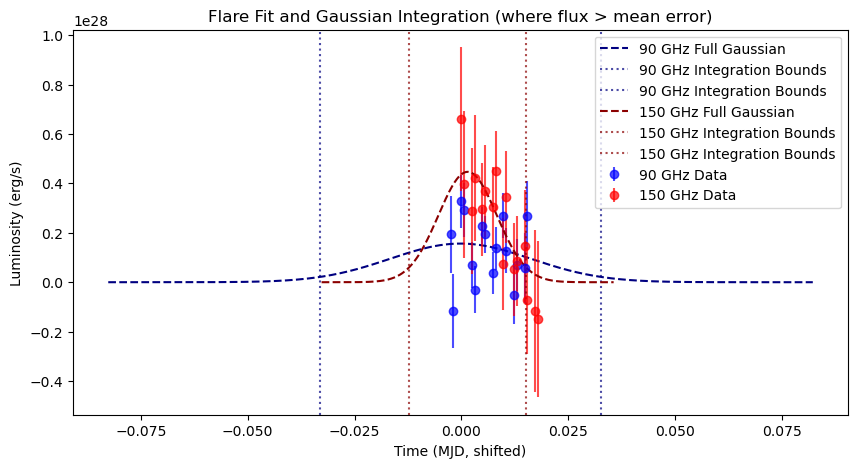

Integrated energy (90 GHz, flux > mean error): 5.326e+30 erg erg
Integrated energy (150 GHz, flux > mean error): 6.306e+30 erg erg
Flare Integral Duration (90 GHz): 5681.98 s
Flare Integral Duration (150 GHz): 2355.08 s


In [11]:
# Calculate mean errors for each band
mean_err_90 = np.mean(np.abs(ss_flux_err_90))
mean_err_150 = np.mean(np.abs(ss_flux_err_150))

# 90 GHz
noise_90 = mean_err_90 / scaling_90
left_bound_90 = t_peak_90 - 2 * sigma_90
right_bound_90 = t_peak_90 + 2 * sigma_90

# Find where the Gaussian drops below the noise level
while gauss(left_bound_90, t_peak_90, amp_90, sigma_90) > noise_90:
    left_bound_90 -= sigma_90 / 100
while gauss(right_bound_90, t_peak_90, amp_90, sigma_90) > noise_90:
    right_bound_90 += sigma_90 / 100

full_times_90 = np.linspace(t_peak_90 - 5 * sigma_90, t_peak_90 + 5 * sigma_90, 500)
full_model_90 = gauss(full_times_90, t_peak_90, amp_90, sigma_90) * scaling_90 * u.mJy
int_mask_90 = (full_times_90 > left_bound_90) & (full_times_90 < right_bound_90)

full_times_90 = full_times_90 * u.day
fluence_90_full = np.trapz(y= full_model_90[int_mask_90], x= full_times_90[int_mask_90].to(u.s))  # Convert to seconds for integration
energy_90_full = (fluence_90_full * (22.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg)

# 150 GHz
noise_150 = mean_err_150 / scaling_150
left_bound_150 = t_peak_150 - 2 * sigma_150
right_bound_150 = t_peak_150 + 2 * sigma_150

# Find where the Gaussian drops below the noise level
while gauss(left_bound_150, t_peak_150, amp_150, sigma_150) > noise_150:
    left_bound_150 -= sigma_150 / 100
while gauss(right_bound_150, t_peak_150, amp_150, sigma_150) > noise_150:
    right_bound_150 += sigma_150 / 100

full_times_150 = np.linspace(t_peak_150 - 5 * sigma_150, t_peak_150 + 5 * sigma_150, 500)
full_model_150 = gauss(full_times_150, t_peak_150, amp_150, sigma_150) * scaling_150 * u.mJy
int_mask_150 = (full_times_150 > left_bound_150) & (full_times_150 < right_bound_150)

full_times_150 = full_times_150 * u.day
fluence_150_full = np.trapz(y= full_model_150[int_mask_150], x= full_times_150[int_mask_150].to(u.s))  # Convert to seconds for integration)
energy_150_full = (fluence_150_full * (37.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg)

plt.figure(figsize=(10, 5))
plt.errorbar(ss_times_90_shifted, ss_flux_90 * 1e-26 * 22.7e9 * (4*np.pi*d**2), yerr=np.abs(ss_flux_err_90) * 1e-26 * 22.7e9 * (4*np.pi*d**2), fmt='o', label='90 GHz Data', color='blue', alpha=0.7)
plt.plot(full_times_90, (full_model_90 * (22.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), '--', color='navy', label='90 GHz Full Gaussian')
# plt.fill_between(full_times_90[int_mask], 0, full_model_90[int_mask], color='navy', alpha=0.1, label='90 GHz Integrated Area (Full)')
plt.axvline(left_bound_90, color='navy', linestyle=':', alpha=0.7, label='90 GHz Integration Bounds')
plt.axvline(right_bound_90, color='navy', linestyle=':', alpha=0.7, label='90 GHz Integration Bounds')

plt.errorbar(ss_times_150_shifted, ss_flux_150 * 1e-26 * 37.7e9 * (4*np.pi*d**2), yerr=np.abs(ss_flux_err_150) * 1e-26 * 37.7e9 * (4*np.pi*d**2), fmt='o', label='150 GHz Data', color='red', alpha=0.7)
plt.plot(full_times_150, (full_model_150 * (37.7e9*u.Hz) * (4*np.pi*d**2)).to(u.erg/u.s), '--', color='darkred', label='150 GHz Full Gaussian')
# plt.fill_between(full_times_150[int_mask], 0, full_model_150[int_mask], color='darkred', alpha=0.1, label='150 GHz Integrated Area (Full)')
plt.axvline(left_bound_150, color='darkred', linestyle=':', alpha=0.7, label='150 GHz Integration Bounds')
plt.axvline(right_bound_150, color='darkred', linestyle=':', alpha=0.7, label='150 GHz Integration Bounds')

plt.xlabel('Time (MJD, shifted)')
plt.ylabel('Luminosity (erg/s)')
plt.title('Flare Fit and Gaussian Integration (where flux > mean error)')
plt.legend()
plt.show()

print(f"Integrated energy (90 GHz, flux > mean error): {energy_90_full:.3e} erg") #± {sigma_E_90:.3e}
print(f"Integrated energy (150 GHz, flux > mean error): {energy_150_full:.3e} erg") #± {sigma_E_150:.3e} 
print(f"Flare Integral Duration (90 GHz): {(full_times_90[int_mask_90][-1] - full_times_90[int_mask_90][0]).to(u.s):.2f}")
print(f"Flare Integral Duration (150 GHz): {(full_times_150[int_mask_150][-1] - full_times_150[int_mask_150][0]).to(u.s):.2f}")